# CS 159 Project: Solving Traveling Salesman Problem (TSP) with Feedback

In [1]:
import inspect
import matplotlib.pyplot as plt
import random
import re
import time
from openai import OpenAI
from sys import maxsize
from tqdm import tqdm
from IPython import get_ipython

In [2]:
ipython = get_ipython()
client = OpenAI(api_key = 'sk-proj-zAfbL0i6aR55d0um6PIbT3BlbkFJmv9ZlKICyHqZbZtuvYJo')
pattern = re.compile(r'```python\n(.*?)```', re.DOTALL)

Generate a heuristic algorithm for TSP directly using GPT 4 Turbo

In [3]:
completion = client.chat.completions.create(
    model='gpt-4-turbo',
    messages=[
    {'role': 'system', 'content': 'You are a coding agent that finds heuristic algorithms for solving NP-complete problems.'},
    {'role': 'user', 'content': 'What is a heuristic algorithm for solving the traveling salesman problem? The input is a graph represented as a dictionary, with integers as keys and list of integers as values for neighboring nodes. The output should be a tuple of the tour and the total cost of the tour. Make sure the code is correct and has polynomial time complexity in the number of nodes. Output only the code with the function and nothing else.'}
  ]
)

In [4]:
def generate_complete_graph(num_nodes):
    graph = {}
    for i in range(num_nodes):
        neighbors = {}
        for j in range(num_nodes):
            if i != j:
                neighbors[j] = random.randint(1, 10)
        graph[i] = neighbors
    return graph

def tour_cost(tour, graph):
    cost = 0
    for i in range(len(tour) - 1):
        cost += graph[tour[i]][tour[i + 1]]
    return cost

Use feedback to help GPT 4 Turbo generate better heuristic algorithms for solving TSP

In [5]:
evaluation = ''.join(inspect.getsourcelines(tour_cost)[0])

graph = generate_complete_graph(10)
completion = client.chat.completions.create(
    model='gpt-4-turbo',
    messages=[
    {'role': 'system', 'content': 'You are a coding agent that finds heuristic algorithms for solving NP-complete problems.'},
    {'role': 'user', 'content': f'What is a heuristic algorithm for solving the traveling salesman problem? The input is a fully connected graph, a nested dictionary with integers as keys representing nodes and dictionaries as values representing neighbors as keys and distances as values in the inner dictionary, such as {graph}. The output should be just the tour, ending at the node it started at. Make sure the code is correct and has polynomial time complexity in the number of nodes and runs successfully on an input, such as {graph}. The code is scored using {evaluation}, with a lower tour cost being better. Output only the code with the function and nothing else.'}
  ]
)
res = completion.choices[0].message.content
code = pattern.findall(res)[0]
feedback = [None, None, None]

for _ in tqdm(range(5)):
    reflection = client.chat.completions.create(
        model='gpt-4-turbo',
        messages=[
        {'role': 'system', 'content': 'You are a thoughtful agent who reflects on the given heuristic algorithm for solving NP-complete problems and give feedback on how to improve the heuristic algorithm while maintaining or improving time complexity.'},
        {'role': 'user', 'content': f'Here is a heuristic algorithm for solving the traveling salesman problem : {code}. Provide a single suggestion on how to improve the heuristic algorithm while maintaining or improving time complexity in words only, no code. Consider heuristic algorithms such as greedy methods, local search, tabu search, simulated annealing, branch and bound, and/or exploiting symmetry'}
    ]
    )
    feedback.append(reflection.choices[0].message.content)
    feedback = feedback[1:]
    completion = client.chat.completions.create(
        model='gpt-4-turbo',
        messages=[
        {'role': 'system', 'content': 'You are a coding agent that finds heuristic algorithms for solving NP-complete problems and takes feedback to improve upon yourself.'},
        {'role': 'user', 'content': f'What is a heuristic algorithm for solving the traveling salesman problem? The input is a fully connected graph, a nested dictionary with integers as keys representing nodes and dictionaries as values representing neighbors as keys and distances as values in the inner dictionary, such as {graph}. The output should be just the tour, ending at the node it started at. Make sure the code is correct and has polynomial time complexity in the number of nodes and runs successfully on an input, such as {graph}. The code is scored using {evaluation}, with a lower tour cost being better. Output only the code with the function and nothing else. Here is some feedback from previous iterations: {feedback[2]}, {feedback[1]}, {feedback[0]}. Here is the current code: {code}. Provide a modification to this code to achieve a lower cost of the tour.'}
    ]
    )
    res = completion.choices[0].message.content
    code = pattern.findall(res)[0]

100%|██████████| 5/5 [04:13<00:00, 50.77s/it]


Optimal algorithm and three heuristic algorithms 

In [6]:
def tsp(graph):
    n = len(graph)
    complete = (1 << n) - 1
    dp = [[-1 for _ in range(n)] for _ in range(1 << n)]
    def tour(mask, city):
        if mask == complete:
            return graph[city][0]
        if dp[mask][city] != -1:
            return dp[mask][city]
        cost = float('inf')
        for next_city in range(n):
            if (mask & (1 << next_city)) == 0:
                new_mask = mask | (1 << next_city)
                cost = min(cost, graph[city][next_city] + tour(new_mask, next_city))
        dp[mask][city] = cost
        return cost
    return tour(1, 0)

def tsp_heuristic(graph):
    nodes = list(graph.keys())
    start_node = nodes[0]
    unvisited = set(nodes)
    tour = [start_node]
    total_cost = 0
    unvisited.remove(start_node)
    current_node = start_node
    while unvisited:
        next_node = None
        min_distance = maxsize
        for neighbor in graph[current_node]:
            if neighbor in unvisited and graph[current_node][neighbor] < min_distance:
                min_distance = graph[current_node][neighbor]
                next_node = neighbor
        if next_node:
            tour.append(next_node)
            total_cost += min_distance
            unvisited.remove(next_node)
            current_node = next_node
        else:
            break
    if start_node in graph[current_node]:
        total_cost += graph[current_node][start_node]
        tour.append(start_node)

    return tour

def tsp_heuristic2(graph):
    n = len(graph)
    if n == 0:
        return ([], 0)
    best_total_cost = float('inf')
    best_tour = []
    for start_node in graph:
        tour = [start_node]
        visited = set(tour)
        total_cost = 0
        current_node = start_node
        while len(tour) < n:
            next_node, next_cost = min(
                ((neighbor, weight) for neighbor, weight in graph[current_node].items() if neighbor not in visited),
                key=lambda x: x[1]
            )
            tour.append(next_node)
            total_cost += next_cost
            visited.add(next_node)
            current_node = next_node
        if start_node in graph[current_node]:
            total_cost += graph[current_node][start_node]
            tour.append(start_node)
        if total_cost < best_total_cost:
            best_total_cost = total_cost
            best_tour = tour
    return best_tour

def tsp_heuristic3(graph):
    def perform_2opt(tour):
        best_tour = tour
        k = 0
        while k < 100:
            k += 1
            improved = False
            for i in range(1, len(best_tour) - 2):
                for j in range(i + 2, len(best_tour)):
                    if tour_cost(best_tour[:i] + best_tour[i:j][::-1] + best_tour[j:], graph) < tour_cost(best_tour, graph):
                        best_tour = best_tour[:i] + best_tour[i:j][::-1] + best_tour[j:]
                        improved = True
                        break
                if improved:
                    break
        return best_tour

    def perform_3opt(tour):
        best_tour = tour
        length = len(tour)
        min_cost = tour_cost(tour, graph)
        for i in range(1, length - 2):
            for j in range(i + 1, length - 1):
                for k in range(j + 1, length):
                    segment1 = best_tour[:i]
                    segment2 = best_tour[i:j]
                    segment3 = best_tour[j:k]
                    segment4 = best_tour[k:]
                    candidates = [
                        segment1 + segment2 + segment3[::-1] + segment4,
                        segment1 + segment2[::-1] + segment3 + segment4,
                        segment1 + segment3 + segment2 + segment4,
                        segment1 + segment3[::-1] + segment2[::-1] + segment4,
                        segment1 + segment2[::-1] + segment3[::-1] + segment4,
                    ]
                    for candidate in candidates:
                        current_cost = tour_cost(candidate, graph)
                        if current_cost < min_cost:
                            min_cost = current_cost
                            best_tour = candidate

        return best_tour

    start_node = list(graph.keys())[0]
    best_tour = None
    best_cost = float('inf')
    for start_node in graph.keys():
        tour = [start_node]
        used_nodes = set(tour)
        current_node = start_node
        while len(tour) < len(graph):
            neighbors = graph[current_node]
            next_node = None
            min_dist = float('inf')
            sorted_neighbors = sorted(neighbors.items(), key=lambda x: x[1])
            for neighbor, dist in sorted_neighbors:
                if neighbor not in used_nodes and dist < min_dist:
                    next_node = neighbor
                    min_dist = dist
            tour.append(next_node)
            used_nodes.add(next_node)
            current_node = next_node
        tour.append(start_node)
        tour = perform_2opt(tour)
        tour = perform_3opt(tour)
        cost = tour_cost(tour, graph)
        if cost < best_cost:
            best_cost = cost
            best_tour = tour
    return best_tour

Compare cost of tour found by a heuristic algorithm directly generated using GPT 4 Turbo versus the optimal algorithm

In [7]:
n = 21
k = 10
x = list(range(4, n, 2))
y1, y2 = [], []
for i in x:
    print(f'Running on graph with {i} nodes')
    cost1, cost2 = 0, 0
    for _ in range(k):
        g = generate_complete_graph(i)
        tour = tsp_heuristic(g)
        cost1 += tour_cost(tour, g)
        cost2 += tsp(g)
    y1.append(cost1 / k)
    y2.append(cost2 / k)

Running on graph with 4 nodes
Running on graph with 6 nodes
Running on graph with 8 nodes
Running on graph with 10 nodes
Running on graph with 12 nodes
Running on graph with 14 nodes
Running on graph with 16 nodes
Running on graph with 18 nodes
Running on graph with 20 nodes


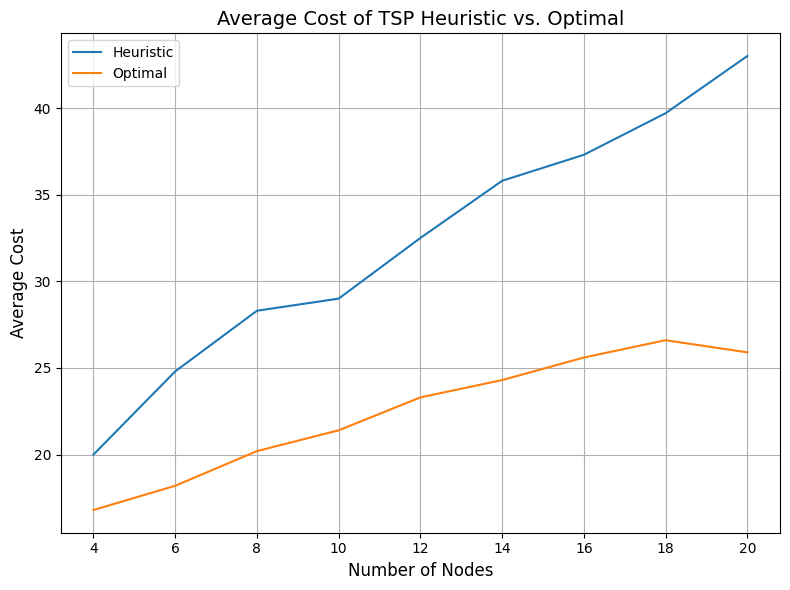

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(x, y1, label='Heuristic')
plt.plot(x, y2, label='Optimal')
plt.legend()
plt.xlabel('Number of Nodes', fontsize=12)
plt.ylabel('Average Cost', fontsize=12)
plt.title('Average Cost of TSP Heuristic vs. Optimal', fontsize=14)
plt.grid(True)
plt.tight_layout()

In [9]:
print(y1)
print(y2)

[20.0, 24.8, 28.3, 29.0, 32.5, 35.8, 37.3, 39.7, 43.0]
[16.8, 18.2, 20.2, 21.4, 23.3, 24.3, 25.6, 26.6, 25.9]


Compre cost of tour found by the three heuristic algorithms generated using GPT 4 Turbo using different amounts of feedback

In [11]:
k = 10
x = list(range(5, 61, 5))
xx = list(range(5, 21, 5))
y1, y2, y3, y4 = [], [], [], []
for i in x:
    print(f'Running on graph with {i} nodes')
    cost1, cost2, cost3, cost4 = 0, 0, 0, 0
    for _ in range(k):
        g = generate_complete_graph(i)
        t1 = tsp_heuristic(g)
        t2 = tsp_heuristic2(g)
        t3 = tsp_heuristic3(g)
        cost1 += tour_cost(t1, g)
        cost2 += tour_cost(t2, g)
        cost3 += tour_cost(t3, g)
        if i <= max(xx):
            cost4 += tsp(g)
    y1.append(cost1 / k)
    y2.append(cost2 / k)
    y3.append(cost3 / k)
    y4.append(cost4 / k)
y4 = y4[:len(xx)]

Running on graph with 5 nodes
Running on graph with 10 nodes
Running on graph with 15 nodes
Running on graph with 20 nodes
Running on graph with 25 nodes
Running on graph with 30 nodes
Running on graph with 35 nodes
Running on graph with 40 nodes
Running on graph with 45 nodes
Running on graph with 50 nodes
Running on graph with 55 nodes
Running on graph with 60 nodes


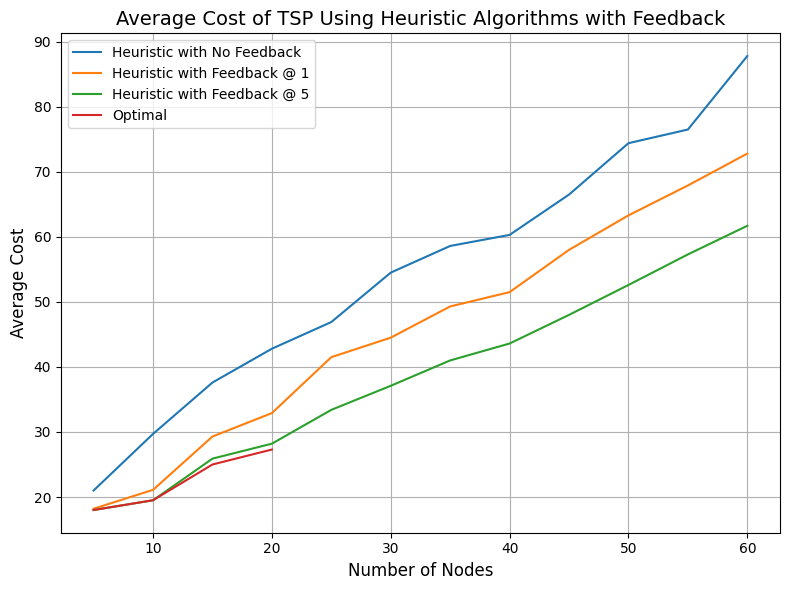

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(x, y1, label='Heuristic with No Feedback')
plt.plot(x, y2, label='Heuristic with Feedback @ 1')
plt.plot(x, y3, label='Heuristic with Feedback @ 5')
plt.plot(xx, y4, label='Optimal')
plt.legend()
plt.xlabel('Number of Nodes', fontsize=12)
plt.ylabel('Average Cost', fontsize=12)
plt.title('Average Cost of TSP Using Heuristic Algorithms with Feedback', fontsize=14)
plt.grid(True)
plt.tight_layout()

In [17]:
n = 21
k = 10
x = list(range(4, n, 2))
y1, y2 = [], []
for i in x:
    print(f'Running on graph with {i} nodes')
    cost1, cost2 = 0, 0
    for _ in range(k):
        g = generate_complete_graph(i)
        tour = tsp_heuristic3(g)
        cost1 += tour_cost(tour, g)
        cost2 += tsp(g)
    y1.append(cost1 / k)
    y2.append(cost2 / k)

Running on graph with 4 nodes
Running on graph with 6 nodes
Running on graph with 8 nodes
Running on graph with 10 nodes
Running on graph with 12 nodes
Running on graph with 14 nodes
Running on graph with 16 nodes
Running on graph with 18 nodes
Running on graph with 20 nodes


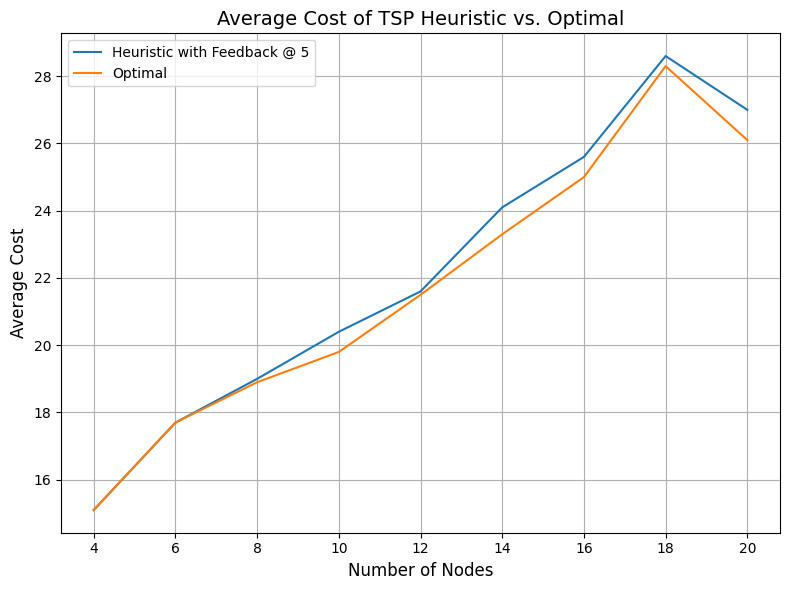

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(x, y1, label='Heuristic with Feedback @ 5')
plt.plot(x, y2, label='Optimal')
plt.legend()
plt.xlabel('Number of Nodes', fontsize=12)
plt.ylabel('Average Cost', fontsize=12)
plt.title('Average Cost of TSP Heuristic vs. Optimal', fontsize=14)
plt.grid(True)
plt.tight_layout()

In [19]:
print(y1)
print(y2)

[15.1, 17.7, 19.0, 20.4, 21.6, 24.1, 25.6, 28.6, 27.0]
[15.1, 17.7, 18.9, 19.8, 21.5, 23.3, 25.0, 28.3, 26.1]


Compare runtime of heuristic algorithm versus optimal algorithm

In [13]:
ms = list(range(5, 41))
ms1 = list(range(5, 26))
t1, t2 = [], []

for m in ms:
    g = generate_complete_graph(m)
    start_time = time.time()
    tsp_heuristic3(g)
    end_time = time.time()
    t1.append(end_time - start_time)
    if m <= max(ms1):
        start_time = time.time()
        tsp(g)
        end_time = time.time()
        t2.append(end_time - start_time)

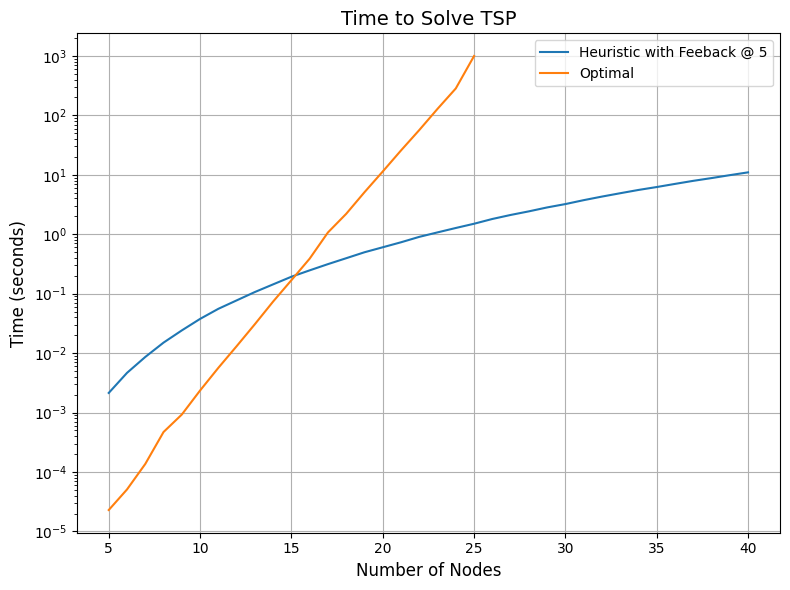

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(ms, t1, label='Heuristic with Feeback @ 5')
plt.plot(ms1, t2, label='Optimal')
plt.legend()
plt.xlabel('Number of Nodes', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Time to Solve TSP', fontsize=14)
plt.grid(True)
plt.yscale('log')
plt.tight_layout()